# UBA - Aprendizaje por Refuerzo I
## Desafío práctico 
#### Alumna Noelia Qualindi
#### Docente Miguel Augusto Azar
- Algoritmos utilizados: Q-Learning, SARSA, MC-ES y MC-IS (ordinary & weighted).

- Link al repositorio GitHub y demo: https://github.com/noequalindi/rl1_gridworld

In [2]:
import numpy as np, random
SEED=42; random.seed(SEED); np.random.seed(SEED)

## Entorno y algoritmos

In [3]:
from dataclasses import dataclass
from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import random

@dataclass
class StepResult:
    next_state: int; reward: float; terminated: bool; truncated: bool; info: dict

class GridWorld:
    def __init__(self, size: int = 4, slip_prob: float = 0.2, max_steps: int = 100):
        self.size = size; self.n_states = size*size; self.n_actions = 4
        self.start_state = 0; self.holes = {5,7,11,12}; self.goal = self.n_states-1
        self.slip_prob = slip_prob; self.max_steps = max_steps; self._steps = 0
        self.state = self.start_state
        
    def reset(self, start_state: int = None) -> int:
        self.state = self.start_state if start_state is None else start_state
        self._steps = 0; return self.state
        
    def _coords(self, s: int) -> Tuple[int,int]: return s//self.size, s%self.size
    
    def _state_from(self, r: int, c: int) -> int: return r*self.size + c
    
    def _move(self, s: int, a: int) -> int:
        r,c = self._coords(s)
        if a==0: c=max(0,c-1)
        elif a==1: r=min(self.size-1,r+1)
        elif a==2: c=min(self.size-1,c+1)
        elif a==3: r=max(0,r-1)
        return self._state_from(r,c)
    def step(self, action: int) -> StepResult:
        self._steps += 1
        if np.random.rand() < self.slip_prob:
            action = np.random.choice([0,1,2,3])
        ns = self._move(self.state, action)
        terminated=False; reward=0.0
        if ns in self.holes: terminated=True
        elif ns==self.goal: terminated=True; reward=1.0
        truncated = self._steps >= self.max_steps
        self.state = ns
        return StepResult(ns, reward, terminated, truncated, {})
      
def epsilon_greedy(q: np.ndarray, s:int, eps:float) -> int:
    return np.random.randint(q.shape[1]) if np.random.rand()<eps else int(np.argmax(q[s]))
  
def moving_average(x,w=100):
    return np.array(x,dtype=float) if len(x)<w else np.convolve(x, np.ones(w)/w, mode='valid')
  
def behavior_prob(state, action, n_actions, epsilon_b=1.0):
    return (1-epsilon_b)*0.0 + epsilon_b*(1.0/n_actions)
  
def train_q_learning(env, n_episodes=4000, alpha=0.8, gamma=0.95, epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.01):
    q=np.zeros((env.n_states,env.n_actions)); rewards=[]
    for _ in range(n_episodes):
        s=env.reset(); tot=0.0
        while True:
            a=epsilon_greedy(q,s,epsilon); res=env.step(a)
            q[s,a]+=alpha*(res.reward + gamma*np.max(q[res.next_state]) - q[s,a])
            s=res.next_state; tot+=res.reward
            if res.terminated or res.truncated: break
        epsilon=max(epsilon_min,epsilon*epsilon_decay); rewards.append(tot)
    return q,rewards
  
def train_sarsa(env, n_episodes=4000, alpha=0.8, gamma=0.95, epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.01):
    q=np.zeros((env.n_states,env.n_actions)); rewards=[]
    for _ in range(n_episodes):
        s=env.reset(); a=epsilon_greedy(q,s,epsilon); tot=0.0
        while True:
            res=env.step(a); sn=res.next_state; an=epsilon_greedy(q,sn,epsilon)
            q[s,a]+=alpha*(res.reward + gamma*q[sn,an] - q[s,a])
            s,a=sn,an; tot+=res.reward
            if res.terminated or res.truncated: break
        epsilon=max(epsilon_min,epsilon*epsilon_decay); rewards.append(tot)
    return q,rewards
  
def train_mc_es(env, n_episodes=4000, gamma=0.95):
    q=np.zeros((env.n_states,env.n_actions)); rewards=[]; rs_sum=np.zeros_like(q); rs_cnt=np.zeros_like(q)+1e-8
    def greedy(s): return int(np.argmax(q[s]))
    for _ in range(n_episodes):
        s0=np.random.randint(env.n_states); a0=np.random.randint(env.n_actions)
        ep=[]; s=env.reset(start_state=s0); first=env.step(a0); ep.append((s,a0,first.reward)); s=first.next_state
        while True:
            a=greedy(s); step=env.step(a); ep.append((s,a,step.reward)); s=step.next_state
            if step.terminated or step.truncated: break
        rewards.append(sum(r for _,_,r in ep)); G=0.0; seen=set()
        for t in reversed(range(len(ep))):
            st,at,rt=ep[t]; G=gamma*G+rt
            if (st,at) not in seen:
                rs_sum[st,at]+=G; rs_cnt[st,at]+=1.0; q[st,at]=rs_sum[st,at]/rs_cnt[st,at]; seen.add((st,at))
    return q,rewards
  
def generate_episode_behavior(env, epsilon_b=1.0):
    s=env.reset(); ep=[]
    while True:
        a=np.random.randint(env.n_actions); res=env.step(a); ep.append((s,a,res.reward)); s=res.next_state
        if res.terminated or res.truncated: break
    return ep
  
def train_mc_is_weighted_control(env, n_episodes=4000, gamma=0.95, epsilon_b=1.0):
    q=np.zeros((env.n_states,env.n_actions)); C=np.zeros_like(q)+1e-8; rewards=[]
    for _ in range(n_episodes):
        ep=generate_episode_behavior(env, epsilon_b=epsilon_b); G=0.0; W=1.0; rewards.append(sum(r for _,_,r in ep))
        for t in reversed(range(len(ep))):
            s,a,r=ep[t]; G=gamma*G+r; C[s,a]+=W; q[s,a]+=(W/C[s,a])*(G-q[s,a])
            if a!=int(np.argmax(q[s])): break
            b=behavior_prob(s,a,env.n_actions,epsilon_b); W*=(1.0/b)
            if W>1e8: break
    return q,rewards
  
  
def train_mc_is_ordinary_control(env, n_episodes=4000, gamma=0.95, epsilon_b=1.0):
    q=np.zeros((env.n_states,env.n_actions)); cnt=np.zeros_like(q)+1e-8; rewards=[]
    for _ in range(n_episodes):
        ep=generate_episode_behavior(env, epsilon_b=epsilon_b); G=0.0; rho=1.0; rewards.append(sum(r for _,_,r in ep))
        for t in reversed(range(len(ep))):
            s,a,r=ep[t]; G=gamma*G+r; cnt[s,a]+=1.0; q[s,a]+=(rho*G-q[s,a])/cnt[s,a]
            if a!=int(np.argmax(q[s])): break
            b=behavior_prob(s,a,env.n_actions,epsilon_b); rho*=(1.0/b)
            if rho>1e8: break
    return q,rewards


## Entrenamiento y gráficos

In [4]:
env = GridWorld(size=4, slip_prob=0.2, max_steps=100)
N=4000
q_ql, r_ql = train_q_learning(env, n_episodes=N)
q_sa, r_sa = train_sarsa(env, n_episodes=N)
q_mc, r_mc = train_mc_es(env, n_episodes=N)
q_mciw, r_mciw = train_mc_is_weighted_control(env, n_episodes=N)
q_mcio, r_mcio = train_mc_is_ordinary_control(env, n_episodes=N)

def plot_series(series, title):
    import matplotlib.pyplot as plt, numpy as _np
    plt.figure(figsize=(8,4.5))
    ma = series if len(series)<100 else _np.convolve(series, _np.ones(100)/100, mode='valid')
    plt.plot(ma)
    plt.title(title); plt.xlabel("Episodios"); plt.ylabel("Reward"); plt.grid(True); plt.show()

plot_series(r_ql, "Q-Learning (MA=100)")
plot_series(r_sa, "SARSA (MA=100)")
plot_series(r_mc, "MC ES (MA=100)")
plot_series(r_mciw, "MC IS Weighted (MA=100)")
plot_series(r_mcio, "MC IS Ordinary (MA=100)")


/var/folders/ml/g_sxsst10mj890krz6gpp0980000gn/T/ipykernel_51481/3905151235.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.title(title); plt.xlabel("Episodios"); plt.ylabel("Reward"); plt.grid(True); plt.show()


In [5]:
# - MC-IS (Ordinary)
# - MC-ES (Exploring Starts)
# - Q-Learning
# - SARSA

from dataclasses import dataclass
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
import os, random

@dataclass
class StepResult:
    next_state: int; reward: float; terminated: bool; truncated: bool; info: dict

class GridWorld:
    def __init__(self, size: int = 4, slip_prob: float = 0.2, max_steps: int = 100):
        self.size = size; self.n_states = size*size; self.n_actions = 4
        self.start_state = 0; self.holes = {5,7,11,12}; self.goal = self.n_states-1
        self.slip_prob = slip_prob; self.max_steps = max_steps; self._steps = 0
        self.state = self.start_state
    def reset(self, start_state: int = None) -> int:
        self.state = self.start_state if start_state is None else start_state
        self._steps = 0; return self.state
    def _coords(self, s: int) -> Tuple[int,int]: return s//self.size, s%self.size
    def _state_from(self, r: int, c: int) -> int: return r*self.size + c
    def _move(self, s: int, a: int) -> int:
        r,c = self._coords(s)
        if a==0: c=max(0,c-1)
        elif a==1: r=min(self.size-1,r+1)
        elif a==2: c=min(self.size-1,c+1)
        elif a==3: r=max(0,r-1)
        return self._state_from(r,c)
    def step(self, action: int) -> StepResult:
        self._steps += 1
        if np.random.rand() < self.slip_prob:
            action = np.random.choice([0,1,2,3])
        ns = self._move(self.state, action)
        terminated=False; reward=0.0
        if ns in self.holes: terminated=True
        elif ns==self.goal: terminated=True; reward=1.0
        truncated = self._steps >= self.max_steps
        self.state = ns
        return StepResult(ns, reward, terminated, truncated, {})

def behavior_prob(state, action, n_actions, epsilon_b=1.0):
    return (1-epsilon_b)*0.0 + epsilon_b*(1.0/n_actions)

def generate_episode_behavior(env, epsilon_b=1.0):
    s=env.reset(); ep=[]
    while True:
        a=np.random.randint(env.n_actions); res=env.step(a); ep.append((s,a,res.reward)); s=res.next_state
        if res.terminated or res.truncated: break
    return ep

def q_to_policy(q, env):
    policy = np.full(env.n_states, -1, dtype=int)
    for s in range(env.n_states):
        if s in env.holes or s == env.goal:
            continue
        policy[s] = int(np.argmax(q[s]))
    return policy

def plot_policy_triangles(policy, env, title, out_path):
    size = env.size
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_title(title)
    ax.set_xlim(-0.5, size-0.5); ax.set_ylim(-0.5, size-0.5)
    ax.set_xticks(range(size)); ax.set_yticks(range(size))
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.invert_yaxis()  # fila 0 arriba
    
    # etiquetas S, G, X (hoyos)
    sr, sc = divmod(env.start_state, size)
    gr, gc = divmod(env.goal, size)
    ax.text(sc, sr, "S", ha="center", va="center")
    ax.text(gc, gr, "G", ha="center", va="center")
    for h in env.holes:
        r, c = divmod(h, size)
        ax.text(c, r, "X", ha="center", va="center")
    
    # triángulos: 0←,1↓,2→,3↑
    markers = {0:"<", 1:"v", 2:">", 3:"^"}
    for s in range(env.n_states):
        if s in env.holes or s == env.goal or s == env.start_state:
            continue
        a = policy[s]
        if a == -1: 
            continue
        r, c = divmod(s, size)
        ax.scatter([c], [r], marker=markers[a], s=500)
    
    fig.tight_layout()
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)

# ----- Algorithms needed -----
def train_q_learning(env, n_episodes=4000, alpha=0.8, gamma=0.95, epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.01):
    q=np.zeros((env.n_states,env.n_actions))
    for _ in range(n_episodes):
        s=env.reset()
        while True:
            a = np.random.randint(env.n_actions) if np.random.rand()<epsilon else int(np.argmax(q[s]))
            res = env.step(a)
            q[s,a] += alpha*(res.reward + gamma*np.max(q[res.next_state]) - q[s,a])
            s = res.next_state
            if res.terminated or res.truncated: break
        epsilon = max(epsilon_min, epsilon*epsilon_decay)
    return q

def train_mc_es(env, n_episodes=4000, gamma=0.95):
    q=np.zeros((env.n_states,env.n_actions)); rs_sum=np.zeros_like(q); rs_cnt=np.zeros_like(q)+1e-8
    def greedy(s): return int(np.argmax(q[s]))
    for _ in range(n_episodes):
        s0=np.random.randint(env.n_states); a0=np.random.randint(env.n_actions)
        ep=[]; s=env.reset(start_state=s0); first=env.step(a0); ep.append((s,a0,first.reward)); s=first.next_state
        while True:
            a=greedy(s); step=env.step(a); ep.append((s,a,step.reward)); s=step.next_state
            if step.terminated or step.truncated: break
        G=0.0; seen=set()
        for t in reversed(range(len(ep))):
            st,at,rt=ep[t]; G=gamma*G+rt
            if (st,at) not in seen:
                rs_sum[st,at]+=G; rs_cnt[st,at]+=1.0; q[st,at]=rs_sum[st,at]/rs_cnt[st,at]; seen.add((st,at))
    return q

def train_mc_is_ordinary_control(env, n_episodes=4000, gamma=0.95, epsilon_b=1.0):
    q=np.zeros((env.n_states,env.n_actions)); cnt=np.zeros_like(q)+1e-8
    for _ in range(n_episodes):
        ep=generate_episode_behavior(env, epsilon_b=epsilon_b); G=0.0; rho=1.0
        for t in reversed(range(len(ep))):
            s,a,r=ep[t]; G=gamma*G+r; cnt[s,a]+=1.0; q[s,a]+=(rho*G-q[s,a])/cnt[s,a]
            if a!=int(np.argmax(q[s])): break
            b=behavior_prob(s,a,env.n_actions,epsilon_b); rho*=(1.0/b)
            if rho>1e8: break
    return q


def train_mc_is_weighted_control(env, n_episodes=4000, gamma=0.95, epsilon_b=1.0):
    q = np.zeros((env.n_states, env.n_actions))
    C = np.zeros_like(q) + 1e-8  # acumulador de pesos por (s,a)

    for _ in range(n_episodes):
        # episodio con política de comportamiento (uniforme si epsilon_b=1.0)
        ep = generate_episode_behavior(env, epsilon_b=epsilon_b)
        G, W = 0.0, 1.0
        for t in reversed(range(len(ep))):
            s, a, r = ep[t]
            G = gamma * G + r
            C[s, a] += W
            q[s, a] += (W / C[s, a]) * (G - q[s, a])  # incremento ponderado

            # control (greedy): si la acción no es la greedy, cortamos
            if a != int(np.argmax(q[s])):
                break

            # razón de importancia con política de comportamiento
            b = behavior_prob(s, a, env.n_actions, epsilon_b)
            W *= (1.0 / b)

            # evitar explosión numérica
            if W > 1e8:
                break
    return q
  

def train_sarsa(env, n_episodes=4000, alpha=0.8, gamma=0.95,
                epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.01):
    q = np.zeros((env.n_states, env.n_actions))
    for _ in range(n_episodes):
        s = env.reset()
        # acción inicial (ε-greedy)
        a = np.random.randint(env.n_actions) if np.random.rand() < epsilon else int(np.argmax(q[s]))
        while True:
            res = env.step(a)
            sn = res.next_state
            # próxima acción (on-policy)
            an = np.random.randint(env.n_actions) if np.random.rand() < epsilon else int(np.argmax(q[sn]))
            # actualización SARSA
            q[s, a] += alpha * (res.reward + gamma * q[sn, an] - q[s, a])
            s, a = sn, an
            if res.terminated or res.truncated:
                break
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
    return q
  
  


## Training 

In [6]:
np.random.seed(42); random.seed(42)
env = GridWorld(size=4, slip_prob=0.2, max_steps=100)

q_ql   = train_q_learning(env, n_episodes=4000)
q_mces = train_mc_es(env, n_episodes=4000)
q_mcio = train_mc_is_ordinary_control(env, n_episodes=4000, epsilon_b=1.0)
q_mciw  = train_mc_is_weighted_control(env, n_episodes=4000, gamma=0.95, epsilon_b=1.0)
q_sa   = train_sarsa(env, n_episodes=4000)

pol_ql   = q_to_policy(q_ql, env)
pol_mces = q_to_policy(q_mces, env)
pol_mcio = q_to_policy(q_mcio, env)
pol_mciw = q_to_policy(q_mciw, env)
pol_sa = q_to_policy(q_sa, env)

os.makedirs("./rl_figs", exist_ok=True)
p1 = "./rl_figs/policy_q_learning.png"
p2 = "./rl_figs/policy_mc_es.png"
p3 = "./rl_figs/policy_mc_is_ordinary.png"
p4 = "./rl_figs/policy_mc_is_weighted.png"
p5 = "./rl_figs/policy_sarsa.png"

plot_policy_triangles(pol_ql,  env, "Política greedy derivada (ε=0) — Q-Learning",        p1)
plot_policy_triangles(pol_mces,env, "Política greedy derivada (ε=0) — MC-ES",             p2)
plot_policy_triangles(pol_mcio,env, "Política greedy derivada (ε=0) — MC-IS (Ordinary)",  p3)
plot_policy_triangles(pol_mciw,env, "Política greedy derivada (ε=0) — MC-IS (Weighted)",  p4)
plot_policy_triangles(pol_sa,  env, "Política greedy derivada (ε=0) — SARSA",   			 p5)

[p1, p2, p3, p4, p5]


['./rl_figs/policy_q_learning.png',
 './rl_figs/policy_mc_es.png',
 './rl_figs/policy_mc_is_ordinary.png',
 './rl_figs/policy_mc_is_weighted.png',
 './rl_figs/policy_sarsa.png']

### Política Greedy: Q-Learning

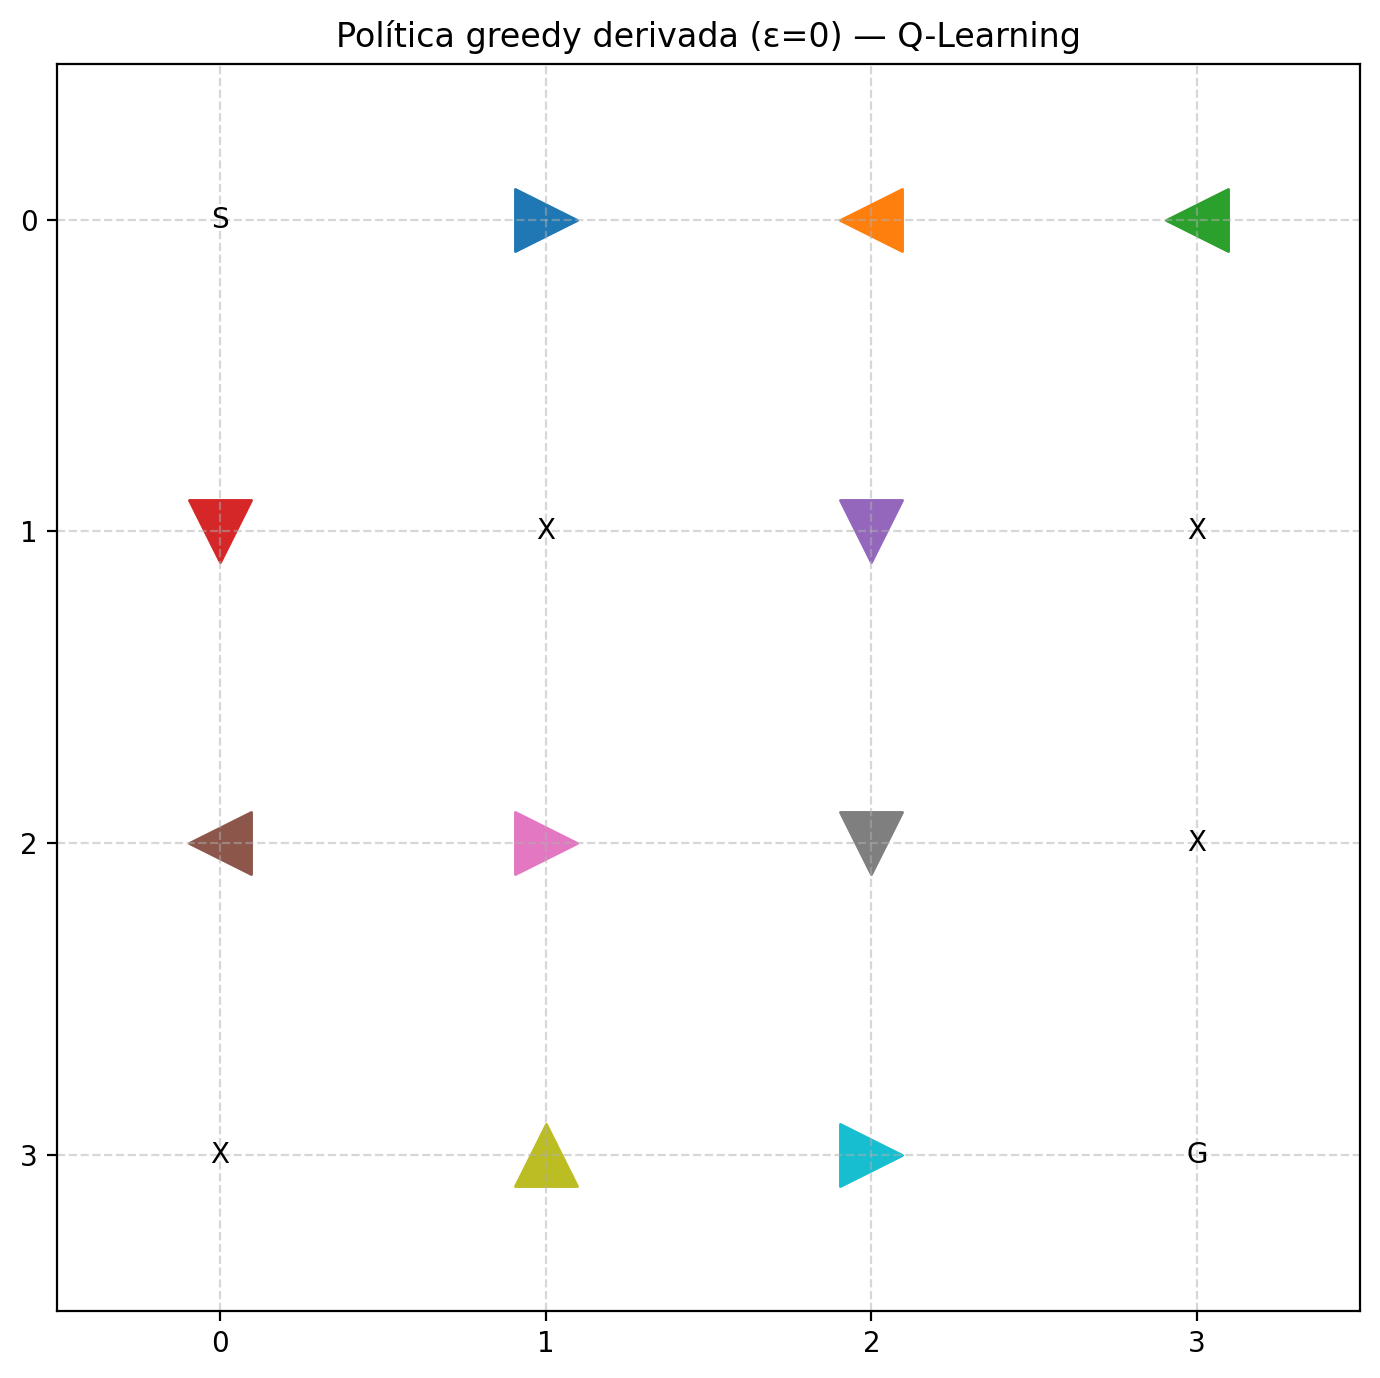

### Política Greedy: MC-ES

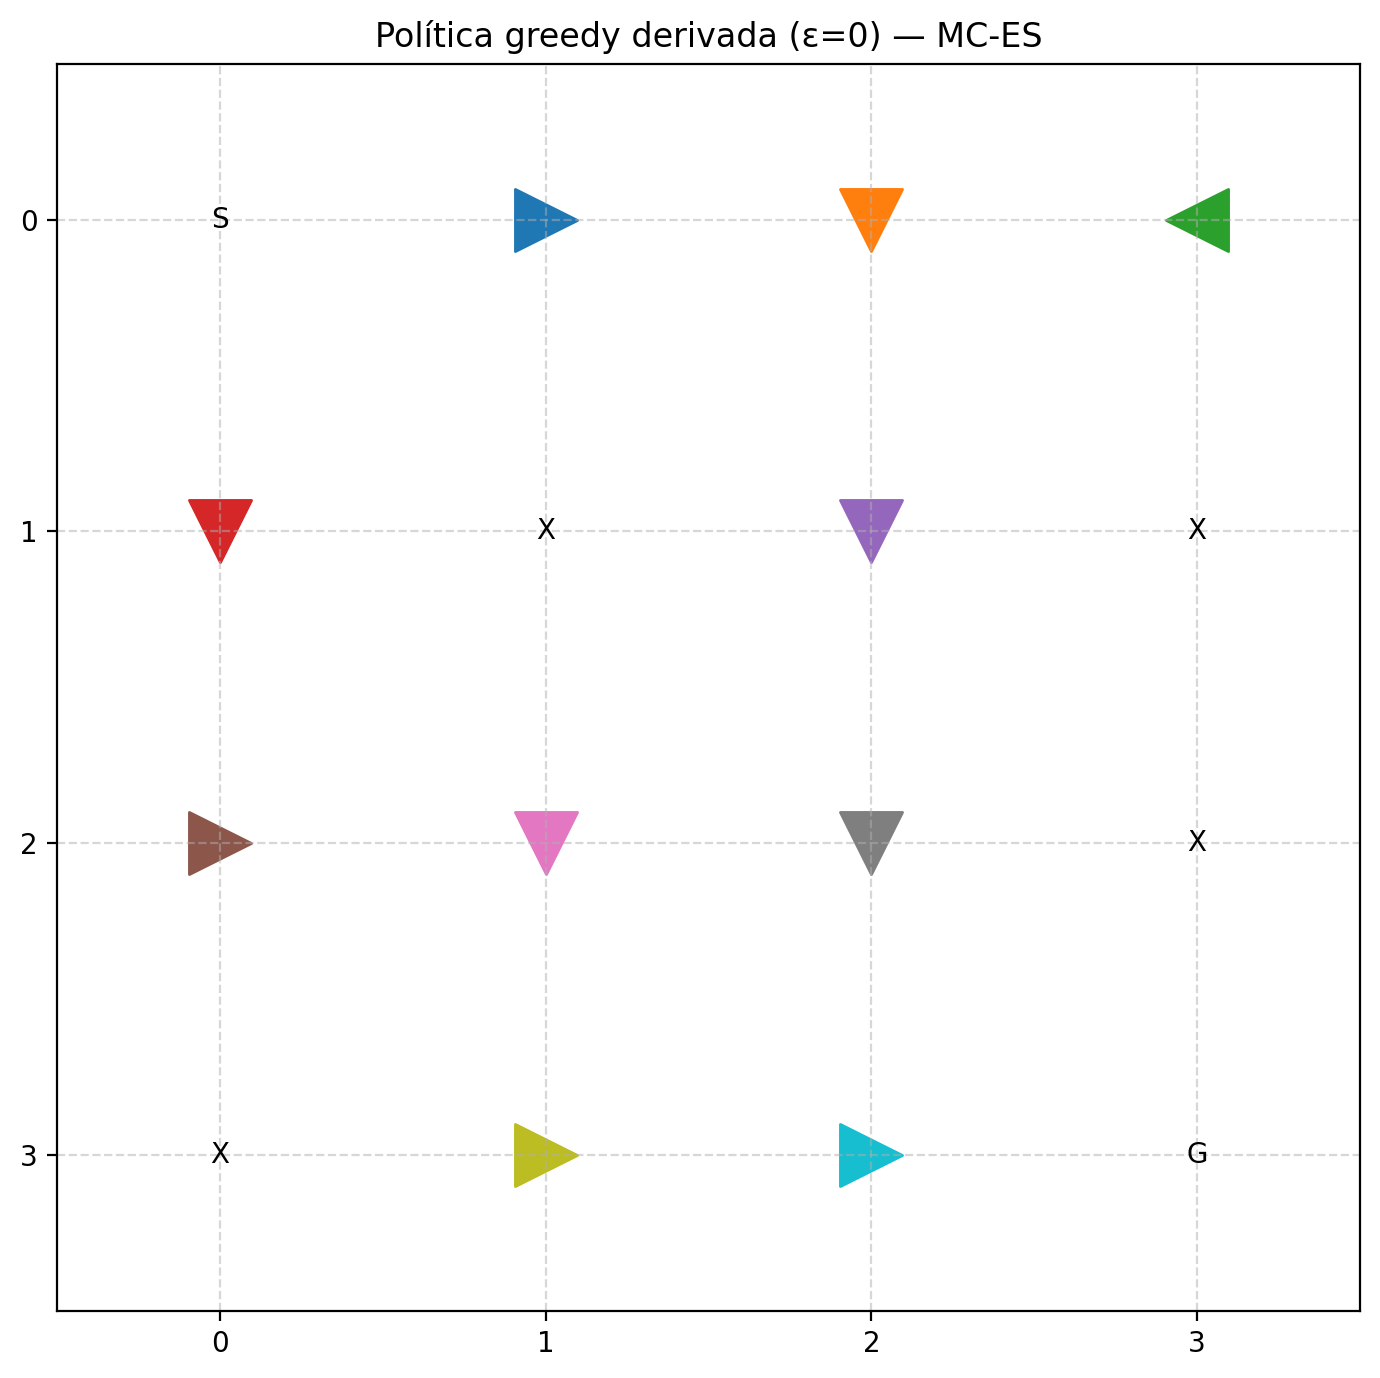

### Política Greedy: MC-IS (Ordinary)

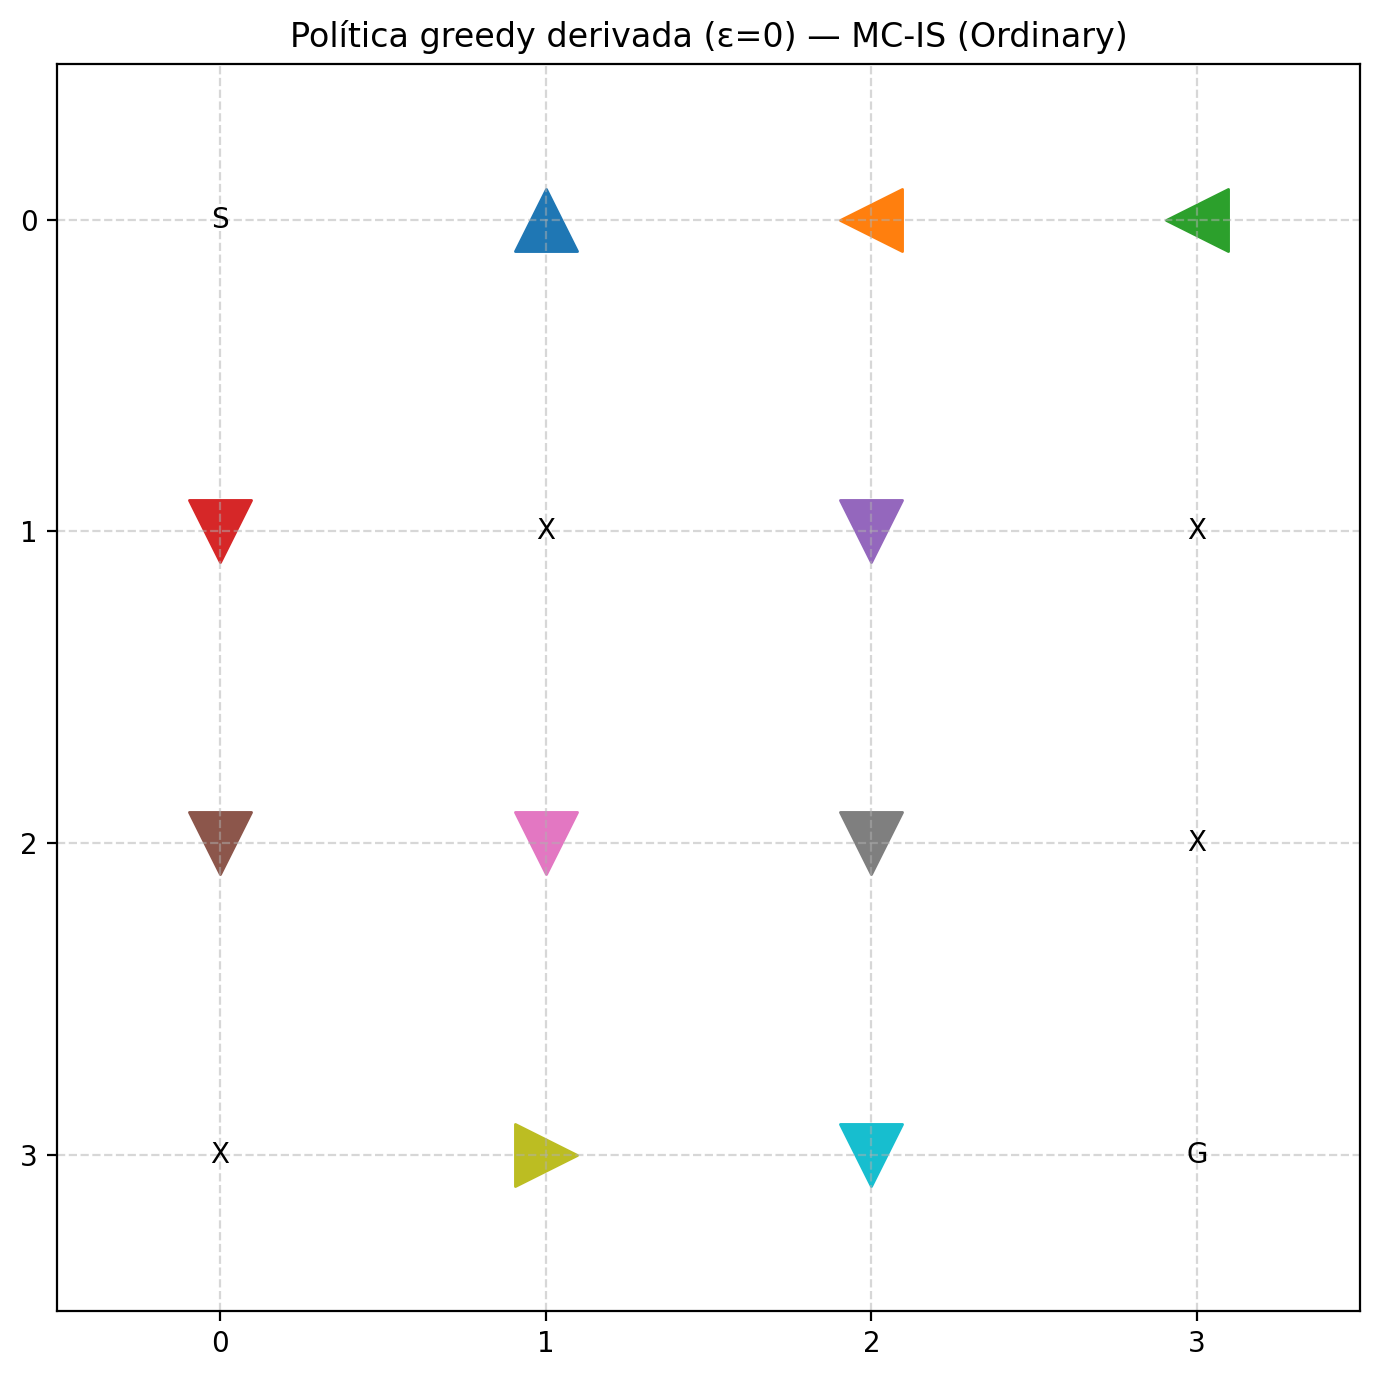

### Política Greedy: MC-IS (Weighted)

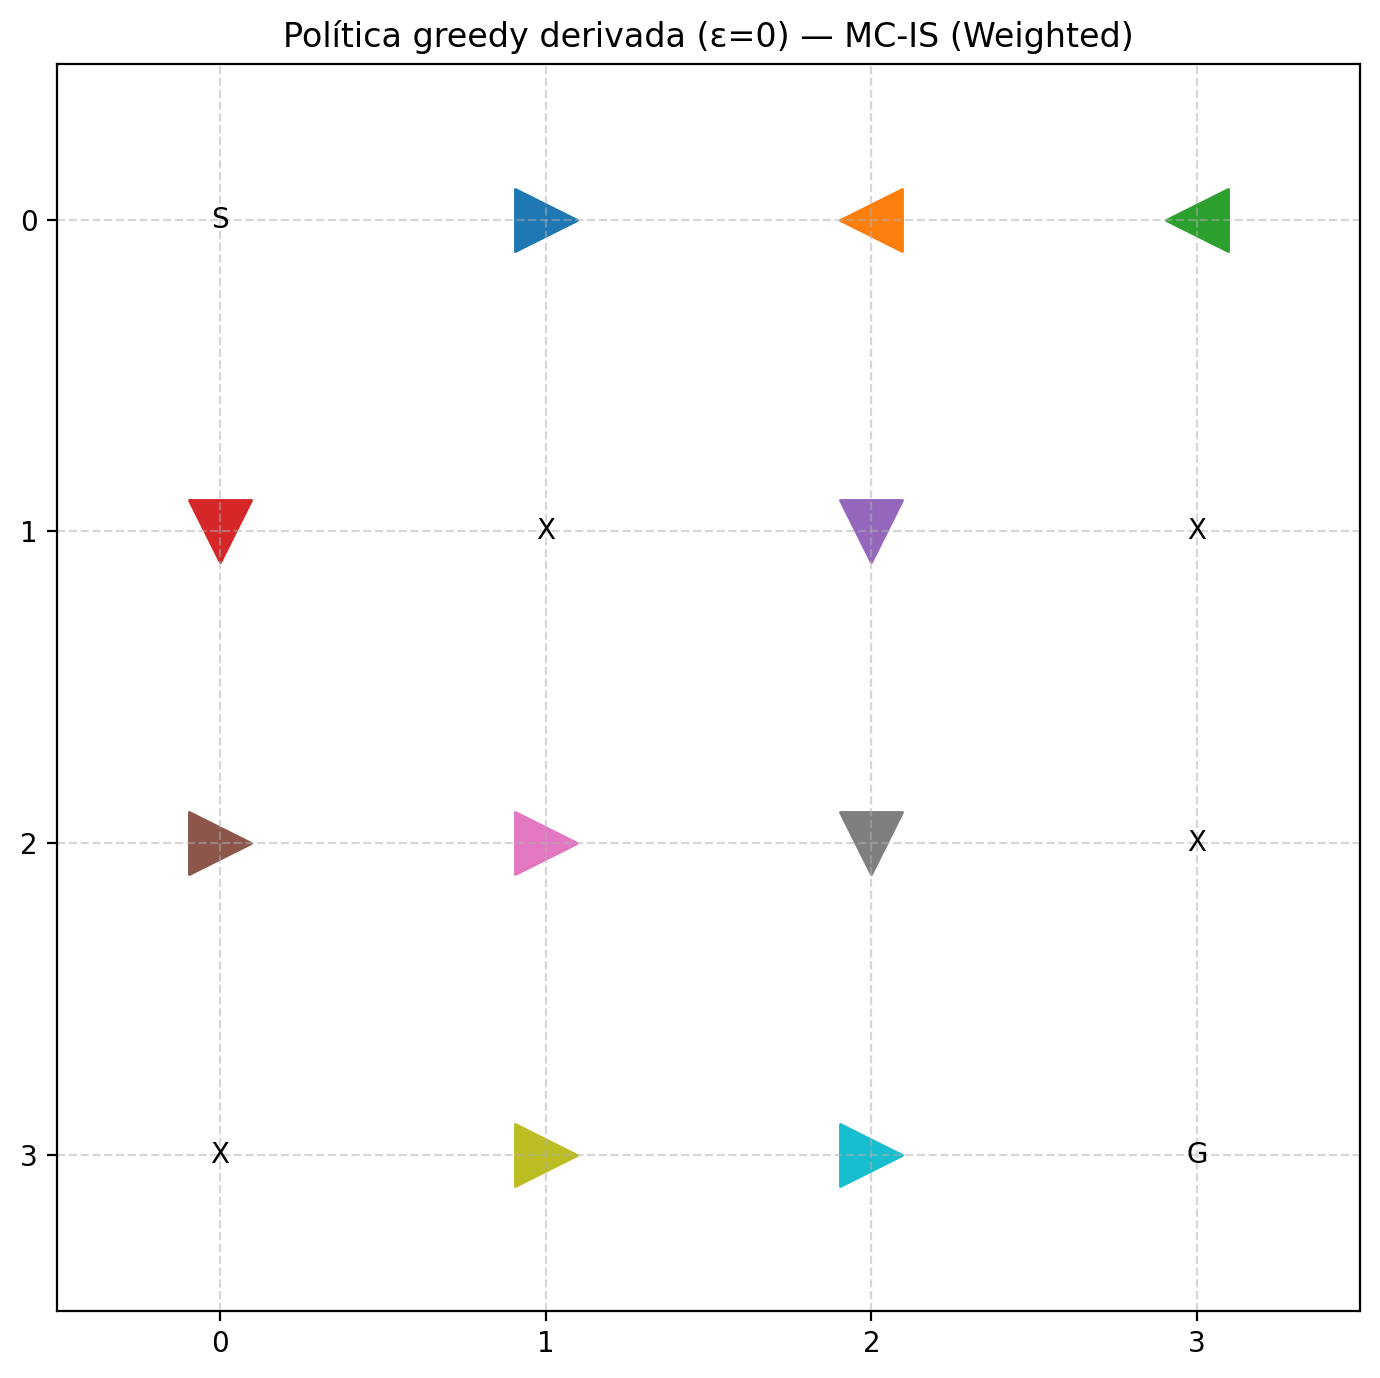

### Política Greedy: SARSA

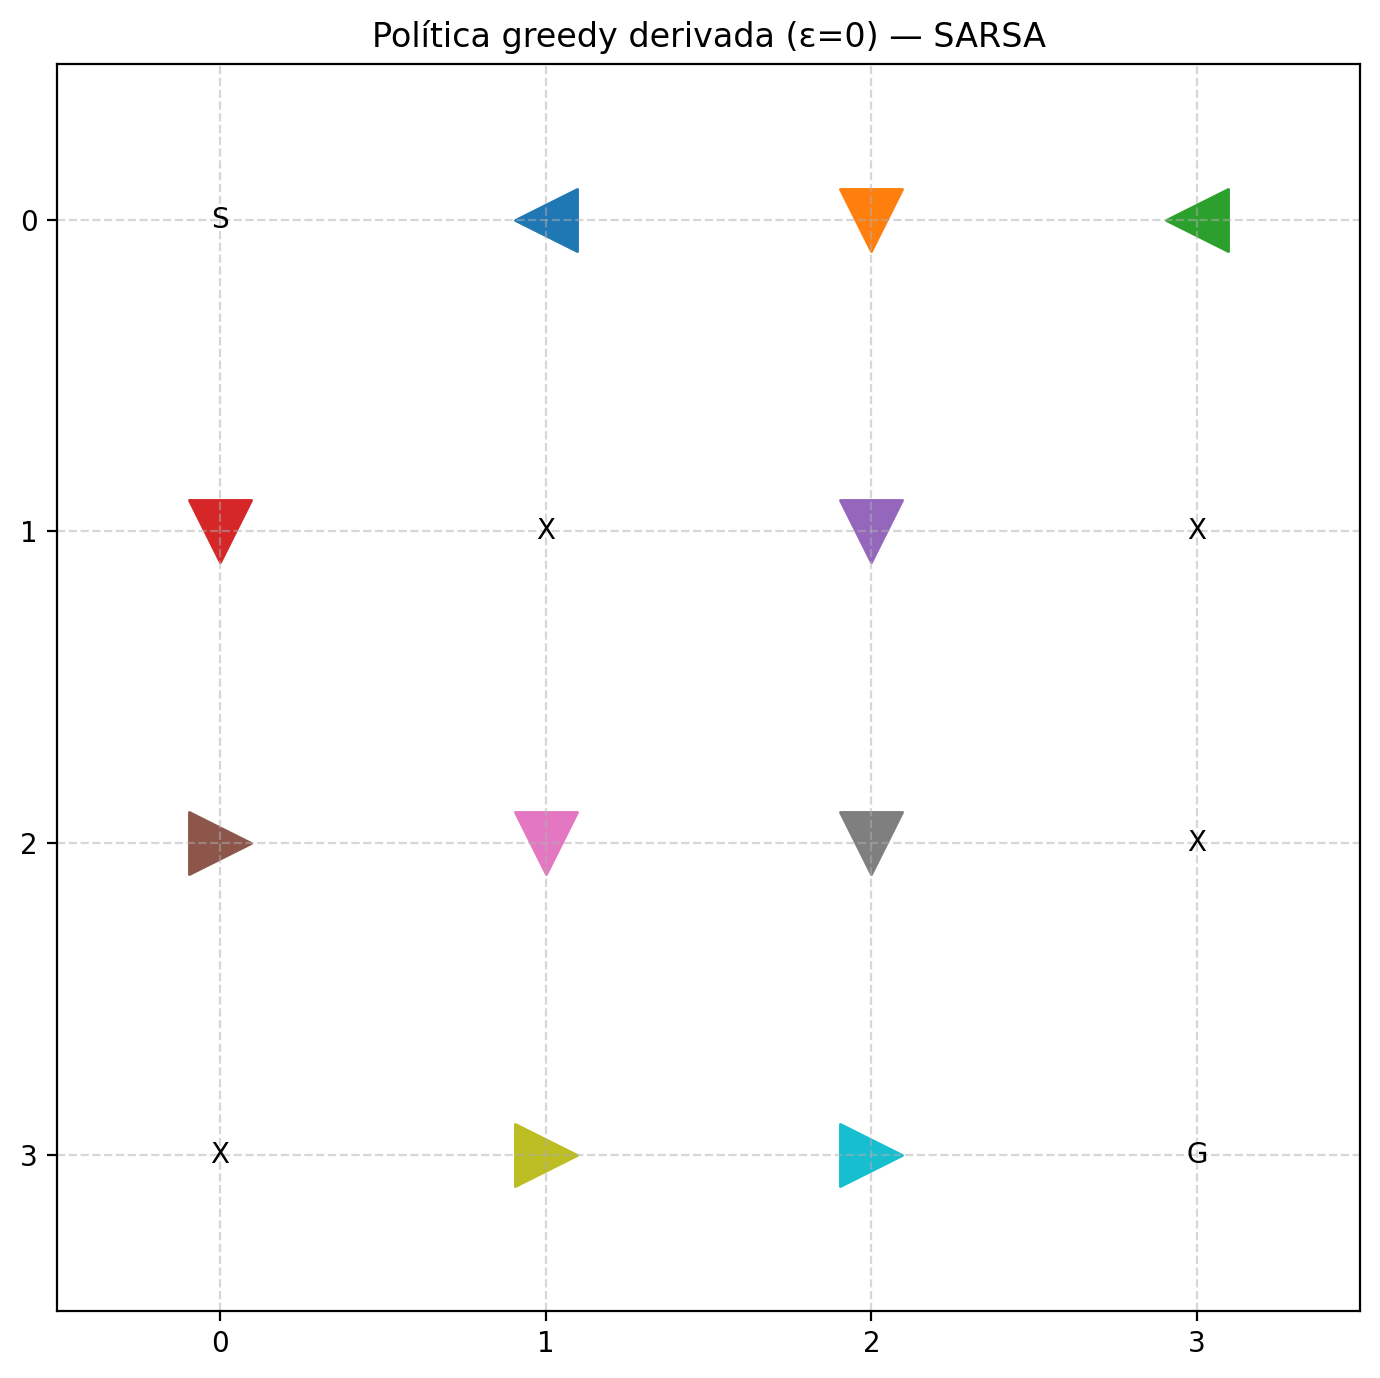

In [7]:
from IPython.display import display, Markdown
from PIL import Image
import os

imgs = [
    ("Política Greedy: Q-Learning", "./rl_figs/policy_q_learning.png"),
    ("Política Greedy: MC-ES", "./rl_figs/policy_mc_es.png"),
    ("Política Greedy: MC-IS (Ordinary)", "./rl_figs/policy_mc_is_ordinary.png"),
    ("Política Greedy: MC-IS (Weighted)", "./rl_figs/policy_mc_is_weighted.png"),
    ("Política Greedy: SARSA", "./rl_figs/policy_sarsa.png"),
]

missing = [p for _, p in imgs if not os.path.exists(p)]
if missing:
    display(Markdown("**Atención:** algunas imágenes no existen aún:\n\n" + "\n".join(f"- {m}" for m in missing)))

for title, path in imgs:
    if os.path.exists(path):
        display(Markdown(f"### {title}"))
        display(Image.open(path))
